# 1. Build your own convolutional neural network using pytorch

In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [2]:
os.listdir('./')

['.config', 'sample_data']

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

MessageError: ignored

In [ ]:
%cd /content/drive/My\ Drive/Colab Notebooks

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        # n = 256
        self.conv1 = nn.Conv2d(3, 64, 3)  # 254
        self.conv2 = nn.Conv2d(64, 64, 3) # 252
        self.conv3 = nn.Conv2d(64, 64, 3) # 250
        self.pool1 = nn.MaxPool2d(2, 2)   # 125

        self.conv4 = nn.Conv2d(64, 128, 3)  # 123
        self.conv5 = nn.Conv2d(128, 128, 3) # 121
        self.conv6 = nn.Conv2d(128, 128, 3) # 119
        self.pool2 = nn.MaxPool2d(2, 2) # 59

        self.conv7 = nn.Conv2d(128, 256, 3) # 57
        self.conv8 = nn.Conv2d(256, 256, 3) # 55
        self.conv9 = nn.Conv2d(256, 256, 3) # 53
        self.pool3 = nn.MaxPool2d(2, 2) # 26

        self.conv10 = nn.Conv2d(256, 512, 3) # 24
        self.conv11 = nn.Conv2d(512, 512, 3) # 22
        self.conv12 = nn.Conv2d(512, 16, 3) # 20
        #self.conv13 = nn.Conv2d(512, 512, 3) # 18
        #self.conv14 = nn.Conv2d(512, 512, 3) # 16
        #self.conv15 = nn.Conv2d(512, 32, 3) # 14
        self.pool4 = nn.MaxPool2d(2, 2) # 10
        
        self.fc1 = nn.Linear(10*10*16, 256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc3 = nn.Linear(64, 4)
        

    def forward(self, x):
  
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))

        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool2(F.relu(self.conv6(x)))

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool3(F.relu(self.conv9(x)))

        x = F.relu(self.conv10(x))
        x = F.relu(self.conv11(x))
        x = self.pool4(F.relu(self.conv12(x)))
        #x = F.relu(self.conv13(x))
        #x = F.relu(self.conv14(x))       
        #x = self.pool4(F.relu(self.conv15(x)))
       
        x = x.view(-1, 10*10*16)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

In [ ]:
train_data_path = './Project1'

In [ ]:
training_transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = training_transform)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=16, shuffle = True)

In [ ]:
test_data_path = './Project11'

In [ ]:
test_transform = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=380, shuffle = False)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
#model = CNet().to(device)
#model1 = CNet().to(device)
model = torch.load('cnn18_20.pt')
#model = torch.load('cnn18_50.pt')
#model = torch.load('ep_300.pt')
#model = torchvision.models.googlenet(pretrained=True)
#model.fc = torch.nn.Linear(in_features=1024, out_features= 4)


In [ ]:
# Define the loss
criterion = nn.CrossEntropyLoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
#torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.7)

In [ ]:
epochs = 50
best_loss = float('inf') # initialize the best loss to a very high value

for e in range(epochs):
    running_loss = 0
    
    # set the model to training mode
    model.train()
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # calculate the average training loss
    train_loss = running_loss / len(train_loader)
    
    # set the model to evaluation mode
    model.eval()
    
    # calculate the validation loss
    valid_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images.to(device))
            loss = criterion(outputs, labels.to(device))
            valid_loss += loss.item()
    
    # calculate the average validation loss
    valid_loss /= len(val_loader)
    
    # print the training and validation losses for each epoch
    print(f"Epoch {e+1}/{epochs}: Train Loss={train_loss:.4f}, Valid Loss={valid_loss:.4f}")
    
    # save the model if the validation loss has improved
    if valid_loss < best_loss:
        torch.save(model.state_dict(), 'cnn10_best.pt')
        best_loss = valid_loss
        
# save the final trained model
torch.save(model.state_dict(), 'cnn10_18.pt')


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in train_loader:
        X,y = data
        outputs = model(X.to(device))
        for idx, i in enumerate(outputs):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Train Accuracy: ", round(correct/total, 3))

In [22]:
def import_test_dataset(root_path, resized_size = (224,224)):
  img_data_files = []
  img_data_names = os.listdir(root_path)
  for img in img_data_names:
    path_=os.path.join(root_path, img)
    img = plt.imread(path_)
    resized = cv2.resize(img, resized_size)
    img_data_files.append(resized.flatten())

  return( (np.array(img_data_files),np.array(img_data_names)) )


In [ ]:
size_of_resized_img = (224,224)
test_data, test_names = import_test_dataset(test_data_path, resized_size= size_of_resized_img)
print(test_data.shape)
print(test_names.shape)

In [24]:
with torch.no_grad():
    for data in test_data:
        X,y = data
        outputs = model(X.to(device))
        test_labels = []
        for idx, i in enumerate(outputs):
            arg = torch.argmax(i).tolist()
            arg += 1
            test_labels.append(arg)
print(test_labels)

[1]


In [ ]:
# Storing the test images and their labels to a csv file

test_data_dir = r'/content/drive/MyDrive/Colab Notebooks/Test'
test_img_list = []

for dir1 in os.listdir(test_data_dir):
    for file in os.listdir(os.path.join(test_data_dir, dir1)):
        test_img_list.append(file)

Test_results = pd.DataFrame(list(zip(test_img_list,test_labels)))
Test_results.to_csv("Results_CNN.csv",header=False,index=False)

# 3. Evaluate your model using the developed software

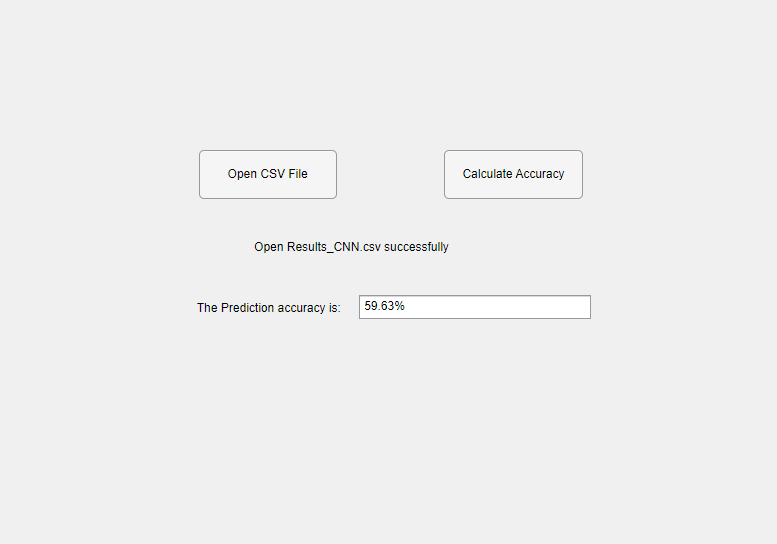

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points